In [1]:
#Taking what we have learned from analyzing the kaggle dataset, we decided that we needed more information to try to  
# predict profit. We are applying what we learned from our Kaggle analysis to our the numbers dataset. 

In [1]:
#Ali and Kendra Final Project 

#importing pandas, csv, 
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
#To create testing and training dfs and labels 
from sklearn.model_selection import train_test_split 
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB
# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score
#confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report
#To get a count or tally of a category in our df 
from collections import Counter
#for pre-processing to fit all numeric data on the standard scale 
from sklearn.preprocessing import StandardScaler
#for applying PCA function on training and testing sets 
from sklearn.decomposition import PCA
#logistic regression 
from sklearn.linear_model import LogisticRegression
#SVMs 
from sklearn.svm import SVC
#For association rule mining 
from apyori import apriori
#This will allow us to silence the warnings
import warnings 
warnings.simplefilter("ignore")
#For the confusion matrix 
import seaborn as sns

In [2]:
#Functions that we are going to use in our file: 

#Creating a function that will change a column data type to category 
def cat_fun(df, column): 
    df[column] = df[column].astype("category") 
    return(df[column])

#Creating a function that will remove anything in our df and replace it with nothing 
def remove(df, column, object_to_remove): 
    df[column] = df[column].str.replace(object_to_remove, "")
    return(df[column])

#Creating a function that will discretize our columns based on quartiles 
def quartile_discretize(df, column, categories): 
    df[column] = pd.qcut(df[column], 4, labels = categories)
    return(df[column])

#Creating a function that will merge our dfs with a left join
def left_merge_2_conditions(df1, df2, column1, column2):
    df = pd.merge(df1, df2, how = "left", on=[column1, column2])
    return(df)

#Creating a function that groups by, counts, creates a new column from the index, drops the index and changes the column names
def groupby_count(df, groupby_column, count_column): 
    new_df = pd.DataFrame(df.groupby(groupby_column)[count_column].count())
    new_df.columns = ["count"]
    new_df[groupby_column] = new_df.index.get_level_values(0)
    new_df.reset_index(drop = True, inplace = True)
    return(new_df)

#Creating a function that groups by, counts, creates a new column from the index, drops the index and changes the column names
def groupby_2_count(df, groupby_column1, groupby_column2, count_column): 
    new_df = pd.DataFrame(df.groupby([groupby_column1, groupby_column2 ])[count_column].count())
    new_df.columns = ["count"]
    new_df[groupby_column1] = new_df.index.get_level_values(0)
    new_df[groupby_column2] = new_df.index.get_level_values(1)
    new_df.reset_index(drop = True, inplace = True)
    return(new_df)

#Creating a function that groups by, counts, creates a new column from the index, drops the index and changes the column names
def groupby_3_count(df, groupby_column1, groupby_column2, groupby_column3, count_column): 
    new_df = pd.DataFrame(df.groupby([groupby_column1, groupby_column2, groupby_column3 ])[count_column].count())
    new_df.columns = ["count"]
    new_df[groupby_column1] = new_df.index.get_level_values(0)
    new_df[groupby_column2] = new_df.index.get_level_values(1)
    new_df[groupby_column3] = new_df.index.get_level_values(2)
    new_df.reset_index(drop = True, inplace = True)
    return(new_df)

# Going to use matplotlib for plotting... 
# To create a plot we followed the following formula: 
# df.plot(x-axis, y-axis, kind = type of plot, color = [(we specified colors to use here)], legend = False (we did not 
# want a legend displayed), title = "Title") then we added a ylabel with plt.ylabel("Type label here") and an x label 
# with plt.xlabel("type label here"). Finally, we wanted to change the direction of the xtick names from a 90 degree angle 
# to no angle with plt.xticks(rotation = rotation angle desired)
def bar_graph_count(df, x_column, y_column, title):
    g = df.plot(x_column, y_column, kind = "bar", legend = False, title = title)
    g = plt.ylabel(y_column)
    g = plt.xlabel(x_column)
    return(g)


#This will calculate the exponential moving average of the columns we want
#exponential moving averages give more weight to the most recent data and less weight to older data 
def exp_moving_avg(d, column_to_be_meaned):
    d["exp_moving_avg"] = d[column_to_be_meaned].ewm(com = 0.5,adjust=False).mean()
    exp_moving_avg = list(d["exp_moving_avg"])
    #Adding a 0 to the first entry to exp_moving_avg
    exp_moving_avg = [0] + exp_moving_avg
    #Removing the last entry in the list 
    exp_moving_avg.pop()
    #Creating a column named exp_moving_avg with the results 
    d["exp_moving_avg"] = exp_moving_avg
    return(exp_moving_avg)

#This will calculate the cumulative moving average
def cumulative_moving_avg(d): 
    d["moving_avg"] = d.expanding(min_periods = 1).mean()
    moving_avg = list(d["moving_avg"])
    #Adding a 0 to the first entry to moving avg
    cumulative_moving_avg = [0] + moving_avg
    #Removing the last entry in the list 
    cumulative_moving_avg.pop()
    return(cumulative_moving_avg)

#This will get the list of all of the entries in the column that we are interested in for calculating the averages
def getting_list_of_entries(df, column_interested_in, column_to_be_meaned): 
    avg_people = pd.DataFrame(df.groupby([column_interested_in, "released"])[column_to_be_meaned].mean())
    avg_column_scores = pd.DataFrame()
    column_interested = list(df[column_interested_in].unique())
    return([avg_people, column_interested])

#This will make a df for our moving averages that we are calculating 
def making_df(people_df, column_interested_in, released, person, cumulative_avg, exp_avg): 
    df_2 = pd.DataFrame({column_interested_in: person, "released": released, "cumulative_mean": cumulative_avg, "exp_mean": exp_avg})
    return(df_2)

#This includes the functions above, and will calculate the exponential and cumulative moving averages for which ever 
#column we specify and return a df will the column interested in, released, cumulative_mean, exp_mean
def calculating_moving_avg(df, column_interested_in, column_to_be_meaned, ty):
    people_df = pd.DataFrame()
    people = getting_list_of_entries(df, column_interested_in, column_to_be_meaned)
    cumulative_avg = []
    avg_people = people[0]
    avg_people
    for person in people[1]: 
        d = avg_people.groupby(column_interested_in).get_group(person)
        cumulative_avg = cumulative_moving_avg(d)
        exp_avg = exp_moving_avg(d, column_to_be_meaned)
        d.reset_index(inplace = True)
        released = d["released"]
        df = pd.DataFrame({column_interested_in: person, "released": released, ty+"_cumulative_mean_"+column_interested_in : cumulative_avg, ty+"_exp_mean_"+column_interested_in: exp_avg})
        people_df = people_df.append(df)
    return(people_df)

#Confusion Matrix Graph Function 
def confusion_matrix_graph (cm, accuracy_label, type_of_df): 
    g = plt.figure(figsize=(2,2))
    g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', cbar = False);
    g = plt.ylabel('Actual');
    g = plt.xlabel('Predicted');
    g = all_sample_title = type_of_df +' Accuracy Score: {0}'.format(round(accuracy_label, 4))
    g = plt.title(all_sample_title, size = 12);
    return(g)

In [3]:
#reading in the V2_TN_reports.csv that we scraped 
movies = pd.read_csv("V2_TN_reports_dates.csv", encoding = "ISO-8859-1")

In [4]:
movies.head()

,Unnamed: 0,CreativeType,DomesticBoxOffice,Genre,Infl.Adj.Dom.BoxOffice,InternationalBoxOffice,MaximumTheaters,OpeningWeekendRevenue,OpeningWeekendTheaters,ProductionBudget,ProductionMethod,Released,ReleasedWorldwide,ReleasedWorldwide_2,Released_2,Source,TheatricalDistributor,TheatricalEngagements,Title,WorldwideBoxOffice
0,0,Fantasy,"$317,871,467",Adventure,"$510,437,208","$657,176,139","3,672","$90,294,621","3,672","$125,000,000",Animation/Live Action,"Nov 16, 2001","Nov 15, 2001",2001,2001,Based on Fiction Book/Short Story,Warner Bros.,"36,120",Harry Potter and the SorcererÃ¢ÂÂs Stone,"$975,047,606"
1,1,Fantasy,"$315,544,750",Adventure,"$502,999,394","$571,666,235","3,381","$47,211,490","3,359","$109,000,000",Animation/Live Action,"Dec 19, 2001","Dec 19, 2001",2001,2001,Based on Fiction Book/Short Story,New Line,"39,234",The Lord of the Rings: The Fellowshipâ¦,"$887,210,985"
2,2,Kids Fiction,"$289,423,425",Adventure,"$449,635,428","$270,334,294","3,649","$62,577,067","3,237","$115,000,000",Digital Animation,"Nov 2, 2001","Nov 2, 2001",2001,2001,Original Screenplay,Walt Disney,"45,411","Monsters, Inc.","$559,757,719"
3,3,Kids Fiction,"$267,655,011",Adventure,"$430,801,615","$224,157,783","3,715","$42,347,760","3,587","$50,000,000",Digital Animation,"May 18, 2001","May 18, 2001",2001,2001,Based on Fiction Book/Short Story,Dreamworks SKG,"40,234",Shrek,"$491,812,794"
4,4,Kids Fiction,"$260,044,825",Adventure,"$438,980,791","$85,096,578","3,256","$55,820,330","3,127","$123,000,000",Live Action,"Nov 17, 2000","Nov 17, 2000",2000,2000,Based on Fiction Book/Short Story,Universal,"27,579",How the Grinch Stole Christmas,"$345,141,403"


In [5]:
#We are dropping the first column named Unnamed:0 
movies.drop("Unnamed: 0", axis = 1, inplace = True)

In [6]:
movies.shape

(1987, 19)

In [7]:
#We have 1987 movies and 19 columns in our current df 
#We are going to drop any rows if they have nas or missing values for budget
movies.dropna(inplace = True)

In [8]:
len(movies)

1971

In [9]:
#We are going to check to see if we have any duplicates 
movies.drop_duplicates(subset ="Title", 
                     keep = "first", inplace = True) 

In [10]:
len(movies.Title.unique())

1060

In [11]:
#We had 16 movies with missing values... 
#Now we are going to drop any movies with 0s in budget 
movies = movies[movies["ProductionBudget"] != "$0"]
movies = movies.reset_index()

In [12]:
len(movies)
#We did not have any movies with a 0 budget 

1060

In [13]:
#We are going to drop any movies with a DomesticBoxOffice of 0 
movies = movies[movies["DomesticBoxOffice"] != "$0"]
movies = movies.reset_index()

In [14]:
len(movies)

1041

In [15]:
#We had 19 movies with missing domestic box office info 

#We are going to change column names to something a little more user friendly. First, we will look at the column names 
movies.columns

Index(['level_0', 'index', 'CreativeType', 'DomesticBoxOffice', 'Genre',
       'Infl.Adj.Dom.BoxOffice', 'InternationalBoxOffice', 'MaximumTheaters',
       'OpeningWeekendRevenue', 'OpeningWeekendTheaters', 'ProductionBudget',
       'ProductionMethod', 'Released', 'ReleasedWorldwide',
       'ReleasedWorldwide_2', 'Released_2', 'Source', 'TheatricalDistributor',
       'TheatricalEngagements', 'Title', 'WorldwideBoxOffice'],
      dtype='object')

In [16]:
movies.drop(['level_0', 'index'], axis = 1, inplace = True)

In [17]:
column_names = ["creative_type", "domestic_box_office", "genre", "inflated_adj_dom_box_office", "int_box_office", "max_theaters", 
                "open_wkend_rev", "open_wkend_theaters", "budget", "production_method", "released", "released_ww", "year",
                "year_ww", "source", "distributor", "engagements", "title", "world_wide_box_office"]
movies.columns = column_names

In [18]:
movies.head()

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,released,released_ww,year,year_ww,source,distributor,engagements,title,world_wide_box_office
0,Fantasy,"$317,871,467",Adventure,"$510,437,208","$657,176,139","3,672","$90,294,621","3,672","$125,000,000",Animation/Live Action,"Nov 16, 2001","Nov 15, 2001",2001,2001,Based on Fiction Book/Short Story,Warner Bros.,"36,120",Harry Potter and the SorcererÃ¢ÂÂs Stone,"$975,047,606"
1,Fantasy,"$315,544,750",Adventure,"$502,999,394","$571,666,235","3,381","$47,211,490","3,359","$109,000,000",Animation/Live Action,"Dec 19, 2001","Dec 19, 2001",2001,2001,Based on Fiction Book/Short Story,New Line,"39,234",The Lord of the Rings: The Fellowshipâ¦,"$887,210,985"
2,Kids Fiction,"$289,423,425",Adventure,"$449,635,428","$270,334,294","3,649","$62,577,067","3,237","$115,000,000",Digital Animation,"Nov 2, 2001","Nov 2, 2001",2001,2001,Original Screenplay,Walt Disney,"45,411","Monsters, Inc.","$559,757,719"
3,Kids Fiction,"$267,655,011",Adventure,"$430,801,615","$224,157,783","3,715","$42,347,760","3,587","$50,000,000",Digital Animation,"May 18, 2001","May 18, 2001",2001,2001,Based on Fiction Book/Short Story,Dreamworks SKG,"40,234",Shrek,"$491,812,794"
4,Kids Fiction,"$260,044,825",Adventure,"$438,980,791","$85,096,578","3,256","$55,820,330","3,127","$123,000,000",Live Action,"Nov 17, 2000","Nov 17, 2000",2000,2000,Based on Fiction Book/Short Story,Universal,"27,579",How the Grinch Stole Christmas,"$345,141,403"


In [19]:
#Looking at the data type for each column in our df 
movies.dtypes

creative_type                  object
domestic_box_office            object
genre                          object
inflated_adj_dom_box_office    object
int_box_office                 object
max_theaters                   object
open_wkend_rev                 object
open_wkend_theaters            object
budget                         object
production_method              object
released                       object
released_ww                    object
year                            int64
year_ww                         int64
source                         object
distributor                    object
engagements                    object
title                          object
world_wide_box_office          object
dtype: object

In [20]:
movies.creative_type.describe()

count                     1041
unique                       8
top       Contemporary Fiction
freq                       441
Name: creative_type, dtype: object

In [21]:
# Eventually, we need to change the following to numeric: 
    # domestic_box_office 
    # inflated_adj_dom_box_office 
    # int_box_office
    # max_theathers 
    # open_wkend_rev 
    # open_wkend_theaters 
    # budget 
    # engagements 
    # world_wide_box_office 
# We need to change the following to category: 
    # creative_type 
    # genre 
    # production_method 
    # source 
    # distributor 
# We need to change the following to date: 
    # released 
    # released ww
#Once we are done cleaning the data we are going to change the data types of the above questions. 
#If we change them now, when we clean the df and removed rows, the old categories 
#remain, and still show as possible categories. 

In [22]:
#First we need to replace the $ and ',' in the columns to be changed to numeric 
#First, creating a list of columns that we want to change to numeric
numeric_columns = ["domestic_box_office", "inflated_adj_dom_box_office", "int_box_office", 
                   "max_theaters", "open_wkend_rev", "open_wkend_theaters", "budget", "engagements", 
                    "world_wide_box_office"]
#We are using our remove function which takes the following arguments: df, column, item to remove
movies["domestic_box_office"] = remove(movies, "domestic_box_office", "$")
movies["domestic_box_office"] = remove(movies, "domestic_box_office", ",")
movies["inflated_adj_dom_box_office"] = remove(movies, "inflated_adj_dom_box_office", "$")
movies["inflated_adj_dom_box_office"] = remove(movies, "inflated_adj_dom_box_office", ",")
movies["int_box_office"] = remove(movies, "int_box_office", "$")
movies["int_box_office"] = remove(movies, "int_box_office", ",")
movies["max_theaters"] = remove(movies, "max_theaters", ",")
movies["open_wkend_theaters"] = remove(movies, "open_wkend_theaters", ",")
movies["open_wkend_rev"] = remove(movies, "open_wkend_rev", "$")
movies["open_wkend_rev"] = remove(movies, "open_wkend_rev", ",")
movies["budget"] = remove(movies, "budget", "$")
movies["budget"] = remove(movies, "budget", ",")
movies["engagements"] = remove(movies, "engagements", ",")
movies["world_wide_box_office"] = remove(movies, "world_wide_box_office", "$")
movies["world_wide_box_office"] = remove(movies, "world_wide_box_office", ",")
#Changing all of the columns in numeric_columns to numeric 
movies[numeric_columns] = movies[numeric_columns].apply(pd.to_numeric)

In [23]:
# We need to change the following to date: released, released ww
movies["released"] = pd.to_datetime(movies["released"])
movies["released_ww"] = pd.to_datetime(movies["released_ww"])
#Separating the month, day and year into their own columns in case we would like to analyze based on month, day or year
movies["month"], movies["day"] = movies["released"].dt.month, movies["released"].dt.day
movies["month_ww"], movies["day_ww"] = movies["released_ww"].dt.month, movies["released_ww"].dt.day

In [24]:
#Checking data types again 
movies.dtypes

creative_type                          object
domestic_box_office                     int64
genre                                  object
inflated_adj_dom_box_office             int64
int_box_office                          int64
max_theaters                            int64
open_wkend_rev                          int64
open_wkend_theaters                     int64
budget                                  int64
production_method                      object
released                       datetime64[ns]
released_ww                    datetime64[ns]
year                                    int64
year_ww                                 int64
source                                 object
distributor                            object
engagements                             int64
title                                  object
world_wide_box_office                   int64
month                                   int64
day                                     int64
month_ww                          

In [25]:
#Changing the month to an ordered category 
cat = list(range(1,13))
#Changing the month data type from int to ordered category 
movies["month"] = pd.Categorical(movies["month"], ordered = True, categories = cat)
movies["month_ww"] = pd.Categorical(movies["month_ww"], ordered = True, categories = cat)
#Checking to see if it worked 
movies.month.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=True)

In [26]:
#Creating columns named domestic_profit, int_profit, ww_profit 
#We want to be able to look at the profit for each movie... Therefore we are creating a 
#profit column which is gross - budget 
movies["dom_profit"] = movies["domestic_box_office"] - movies["budget"]
movies["int_profit"] = movies["int_box_office"] - movies["budget"]
movies["ww_profit"] = movies["world_wide_box_office"] - movies["budget"]

In [27]:
#Looking to see if that helped
movies.head()

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,...,engagements,title,world_wide_box_office,month,day,month_ww,day_ww,dom_profit,int_profit,ww_profit
0,Fantasy,317871467,Adventure,510437208,657176139,3672,90294621,3672,125000000,Animation/Live Action,...,36120,Harry Potter and the SorcererÃ¢ÂÂs Stone,975047606,11,16,11,15,192871467,532176139,850047606
1,Fantasy,315544750,Adventure,502999394,571666235,3381,47211490,3359,109000000,Animation/Live Action,...,39234,The Lord of the Rings: The Fellowshipâ¦,887210985,12,19,12,19,206544750,462666235,778210985
2,Kids Fiction,289423425,Adventure,449635428,270334294,3649,62577067,3237,115000000,Digital Animation,...,45411,"Monsters, Inc.",559757719,11,2,11,2,174423425,155334294,444757719
3,Kids Fiction,267655011,Adventure,430801615,224157783,3715,42347760,3587,50000000,Digital Animation,...,40234,Shrek,491812794,5,18,5,18,217655011,174157783,441812794
4,Kids Fiction,260044825,Adventure,438980791,85096578,3256,55820330,3127,123000000,Live Action,...,27579,How the Grinch Stole Christmas,345141403,11,17,11,17,137044825,-37903422,222141403


In [28]:
#Creating a percent profit column to have a normalized way to compare profits. 
#percent_profit = profit/budget*100 
movies["dom_percent_profit"] = movies["dom_profit"]/movies["budget"]*100
movies["int_percent_profit"] = movies["int_profit"]/movies["budget"]*100
movies["ww_percent_profit"] = movies["ww_profit"]/movies["budget"]*100

In [29]:
#checking to see that worked 
movies.head()
#Writing the clean version of the df to a csv file 
#movies.to_csv("clean.csv", index = False)

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,...,month,day,month_ww,day_ww,dom_profit,int_profit,ww_profit,dom_percent_profit,int_percent_profit,ww_percent_profit
0,Fantasy,317871467,Adventure,510437208,657176139,3672,90294621,3672,125000000,Animation/Live Action,...,11,16,11,15,192871467,532176139,850047606,154.297174,425.740911,680.038085
1,Fantasy,315544750,Adventure,502999394,571666235,3381,47211490,3359,109000000,Animation/Live Action,...,12,19,12,19,206544750,462666235,778210985,189.490596,424.464436,713.955032
2,Kids Fiction,289423425,Adventure,449635428,270334294,3649,62577067,3237,115000000,Digital Animation,...,11,2,11,2,174423425,155334294,444757719,151.672543,135.073299,386.745843
3,Kids Fiction,267655011,Adventure,430801615,224157783,3715,42347760,3587,50000000,Digital Animation,...,5,18,5,18,217655011,174157783,441812794,435.310022,348.315566,883.625588
4,Kids Fiction,260044825,Adventure,438980791,85096578,3256,55820330,3127,123000000,Live Action,...,11,17,11,17,137044825,-37903422,222141403,111.418557,-30.815790,180.602767


In [30]:
# #For some reason the functions do not work without rereading in the csv file... 
# movies = pd.read_csv("clean.csv", encoding = "ISO-8859-1")

In [31]:
len(movies.domestic_box_office.unique())

1041

In [32]:
#Aggregating a moving average column and calculating the mean average pp for each creative type;
#by calculating the mean pp for all creative types but for only the movies prior to the 
#movie we are calculting the mean for. 
dom_ct_ma = calculating_moving_avg(movies, "creative_type", "dom_percent_profit", "dom")
int_ct_ma = calculating_moving_avg(movies, "creative_type", "int_percent_profit", "int")
ww_ct_ma = calculating_moving_avg(movies, "creative_type", "ww_percent_profit", "ww")
# #Genres: 
dom_genre_ma = calculating_moving_avg(movies, "genre", "dom_percent_profit", "dom")
int_genre_ma = calculating_moving_avg(movies, "genre", "int_percent_profit", "int")
ww_genre_ma = calculating_moving_avg(movies, "genre", "ww_percent_profit", "ww")
# production_method: 
dom_pm_ma = calculating_moving_avg(movies, "production_method", "dom_percent_profit", "dom")
int_pm_ma = calculating_moving_avg(movies, "production_method", "int_percent_profit", "int")
ww_pm_ma = calculating_moving_avg(movies, "production_method", "ww_percent_profit", "ww")
# source
dom_source_ma = calculating_moving_avg(movies, "source", "dom_percent_profit", "dom")
int_source_ma = calculating_moving_avg(movies, "source", "int_percent_profit", "int")
ww_source_ma = calculating_moving_avg(movies, "source", "ww_percent_profit", "ww")
# distributor: 
dom_distributor_ma = calculating_moving_avg(movies, "distributor", "dom_percent_profit", "dom")
int_distributor_ma = calculating_moving_avg(movies, "distributor", "int_percent_profit", "int")
ww_distributor_ma = calculating_moving_avg(movies, "distributor", "ww_percent_profit", "ww")
#Month 
dom_month_ma = calculating_moving_avg(movies, "month", "dom_percent_profit", "dom")
int_month_ma = calculating_moving_avg(movies, "month", "int_percent_profit", "int")
ww_month_ma = calculating_moving_avg(movies, "month", "ww_percent_profit", "ww")


In [33]:
#We are going to use our left_merge_2_conditions function: 
#Inputs: df1, df2, column to merge on 1 and column to merge on 2 

#Creating a movies domestic df 
movies_dom = left_merge_2_conditions(movies, dom_ct_ma, "creative_type", "released")
movies_dom = left_merge_2_conditions(movies_dom, dom_genre_ma, "genre", "released")
movies_dom = left_merge_2_conditions(movies_dom, dom_pm_ma, "production_method", "released")
movies_dom = left_merge_2_conditions(movies_dom, dom_source_ma, "source", "released")
movies_dom = left_merge_2_conditions(movies_dom, dom_distributor_ma, "distributor", "released")
movies_dom = left_merge_2_conditions(movies_dom, dom_month_ma, "month", "released")

#Creating a movies_int df 
movies_int = left_merge_2_conditions(movies, int_ct_ma, "creative_type", "released")
movies_int = left_merge_2_conditions(movies_int, int_genre_ma, "genre", "released")
movies_int = left_merge_2_conditions(movies_int, int_pm_ma, "production_method", "released")
movies_int = left_merge_2_conditions(movies_int, int_source_ma, "source", "released")
movies_int = left_merge_2_conditions(movies_int, int_distributor_ma, "distributor", "released")
movies_int = left_merge_2_conditions(movies_int, int_month_ma, "month", "released")

#Creating a movies_ww df 
movies_ww = left_merge_2_conditions(movies, ww_ct_ma, "creative_type", "released")
movies_ww = left_merge_2_conditions(movies_ww, ww_genre_ma, "genre", "released")
movies_ww = left_merge_2_conditions(movies_ww, ww_pm_ma, "production_method", "released")
movies_ww = left_merge_2_conditions(movies_ww, ww_source_ma, "source", "released")
movies_ww = left_merge_2_conditions(movies_ww, ww_distributor_ma, "distributor", "released")
movies_ww = left_merge_2_conditions(movies_ww, ww_month_ma, "month", "released")



In [34]:
#Looking at the movies_dom df head 
len(movies_dom)

1041

In [35]:
#Getting the column names for movies_dom
movies_dom.columns

Index(['creative_type', 'domestic_box_office', 'genre',
       'inflated_adj_dom_box_office', 'int_box_office', 'max_theaters',
       'open_wkend_rev', 'open_wkend_theaters', 'budget', 'production_method',
       'released', 'released_ww', 'year', 'year_ww', 'source', 'distributor',
       'engagements', 'title', 'world_wide_box_office', 'month', 'day',
       'month_ww', 'day_ww', 'dom_profit', 'int_profit', 'ww_profit',
       'dom_percent_profit', 'int_percent_profit', 'ww_percent_profit',
       'dom_cumulative_mean_creative_type', 'dom_exp_mean_creative_type',
       'dom_cumulative_mean_genre', 'dom_exp_mean_genre',
       'dom_cumulative_mean_production_method',
       'dom_exp_mean_production_method', 'dom_cumulative_mean_source',
       'dom_exp_mean_source', 'dom_cumulative_mean_distributor',
       'dom_exp_mean_distributor', 'dom_cumulative_mean_month',
       'dom_exp_mean_month'],
      dtype='object')

In [36]:
#removing released_ww, year_ww, world_wide_box_office, month_ww, day_ww, int_profit, ww_profit
columns_to_remove = ["released_ww", "year_ww", "world_wide_box_office", "month_ww", "day_ww", "int_profit", "ww_profit", "int_percent_profit", "ww_percent_profit", "int_box_office", 
                    "domestic_box_office", "inflated_adj_dom_box_office", "max_theaters", "engagements", "dom_profit"]
movies_dom.drop(columns_to_remove, axis = 1, inplace = True)
movies_dom.columns

Index(['creative_type', 'genre', 'open_wkend_rev', 'open_wkend_theaters',
       'budget', 'production_method', 'released', 'year', 'source',
       'distributor', 'title', 'month', 'day', 'dom_percent_profit',
       'dom_cumulative_mean_creative_type', 'dom_exp_mean_creative_type',
       'dom_cumulative_mean_genre', 'dom_exp_mean_genre',
       'dom_cumulative_mean_production_method',
       'dom_exp_mean_production_method', 'dom_cumulative_mean_source',
       'dom_exp_mean_source', 'dom_cumulative_mean_distributor',
       'dom_exp_mean_distributor', 'dom_cumulative_mean_month',
       'dom_exp_mean_month'],
      dtype='object')

In [37]:
#Creating an aggregated column to see if the open_wken_rev/open_wkend_theaters shows if a movie is in more demand 
movies_dom["open_wkend_rev/open_wkend_theaters"] = movies_dom["open_wkend_rev"]/movies_dom["open_wkend_theaters"]

In [38]:
#We are removing any rows that have 0s for the newly calculated columns 
#Looking to see what happens if we remove all the movies with a 0 for exp_mean_director and exp_mean_star
movies_dom = movies_dom[movies_dom["dom_cumulative_mean_creative_type"] != 0]
movies_dom = movies_dom[movies_dom["dom_cumulative_mean_genre"] != 0]
movies_dom = movies_dom[movies_dom["dom_cumulative_mean_production_method"] != 0]
movies_dom = movies_dom[movies_dom["dom_cumulative_mean_source"] != 0]
movies_dom = movies_dom[movies_dom["dom_cumulative_mean_distributor"] != 0]
movies_dom = movies_dom[movies_dom["dom_cumulative_mean_month"] != 0]

movies_dom.dropna(inplace = True)

In [39]:
len(movies_dom) #We still have 1859 movies in our df 

968

In [40]:
#Changing creative_type, genre, production_method, source, distributor to category 
#We are using our cat_fun which takes the following inputs: df, column to change
movies_dom["creative_type"] = cat_fun(movies_dom, "creative_type")
movies_dom["genre"] = cat_fun(movies_dom, "genre")
movies_dom["production_method"] = cat_fun(movies_dom, "production_method")
movies_dom["source"] = cat_fun(movies_dom, "source")
movies_dom["distributor"] = cat_fun(movies_dom, "distributor")

In [41]:
#Repeating the above process for movies_int 
#Looking at the movies_int columns 
movies_int.columns 

Index(['creative_type', 'domestic_box_office', 'genre',
       'inflated_adj_dom_box_office', 'int_box_office', 'max_theaters',
       'open_wkend_rev', 'open_wkend_theaters', 'budget', 'production_method',
       'released', 'released_ww', 'year', 'year_ww', 'source', 'distributor',
       'engagements', 'title', 'world_wide_box_office', 'month', 'day',
       'month_ww', 'day_ww', 'dom_profit', 'int_profit', 'ww_profit',
       'dom_percent_profit', 'int_percent_profit', 'ww_percent_profit',
       'int_cumulative_mean_creative_type', 'int_exp_mean_creative_type',
       'int_cumulative_mean_genre', 'int_exp_mean_genre',
       'int_cumulative_mean_production_method',
       'int_exp_mean_production_method', 'int_cumulative_mean_source',
       'int_exp_mean_source', 'int_cumulative_mean_distributor',
       'int_exp_mean_distributor', 'int_cumulative_mean_month',
       'int_exp_mean_month'],
      dtype='object')

In [42]:
#Removing columns that might unduly influence our prediction method for movies_int 
columns_to_remove = ["domestic_box_office", "inflated_adj_dom_box_office", "int_box_office", "max_theaters", "world_wide_box_office", 
                    "engagements", "dom_profit", "int_profit", "ww_profit", "dom_percent_profit", "ww_percent_profit", 
                    "released", "year", "month", "day"]
movies_int.drop(columns_to_remove, axis = 1, inplace = True)
movies_int.columns

Index(['creative_type', 'genre', 'open_wkend_rev', 'open_wkend_theaters',
       'budget', 'production_method', 'released_ww', 'year_ww', 'source',
       'distributor', 'title', 'month_ww', 'day_ww', 'int_percent_profit',
       'int_cumulative_mean_creative_type', 'int_exp_mean_creative_type',
       'int_cumulative_mean_genre', 'int_exp_mean_genre',
       'int_cumulative_mean_production_method',
       'int_exp_mean_production_method', 'int_cumulative_mean_source',
       'int_exp_mean_source', 'int_cumulative_mean_distributor',
       'int_exp_mean_distributor', 'int_cumulative_mean_month',
       'int_exp_mean_month'],
      dtype='object')

In [43]:
#Aggregating a new column for open_wken_rev_by_theater; we think that it might show if a movie is more in demand or not. 
#If a movie made $1 million, but was only shown in 100 theaters and another movie made $1 million but was shown, in 300 
#theaters, it might show that movie 1 was more in demand than movie 2... 
movies_int["open_wkend_rev/open_wkend_theaters"] = movies_int["open_wkend_rev"]/movies_int["open_wkend_theaters"]

In [44]:
#We are removing any rows that have 0s for the newly calculated columns 
#Looking to see what happens if we remove all the movies with a 0 for exp_mean_director and exp_mean_star
movies_int = movies_int[movies_int["int_cumulative_mean_creative_type"] != 0]
movies_int = movies_int[movies_int["int_cumulative_mean_genre"] != 0]
movies_int = movies_int[movies_int["int_cumulative_mean_production_method"] != 0]
movies_int = movies_int[movies_int["int_cumulative_mean_source"] != 0]
movies_int = movies_int[movies_int["int_cumulative_mean_distributor"] != 0]
movies_int = movies_int[movies_int["int_cumulative_mean_month"] != 0]

movies_int.dropna(inplace = True)

In [45]:
#We still have 1859 movies after removing any of the aggregated columns with a 0 in them 
len(movies_int)

968

In [46]:
#Changing creative_type, genre, production_method, source, distributor to category 
#We are using our cat_fun which takes the following inputs: df, column to change
movies_int["creative_type"] = cat_fun(movies_int, "creative_type")
movies_int["genre"] = cat_fun(movies_int, "genre")
movies_int["production_method"] = cat_fun(movies_int, "production_method")
movies_int["source"] = cat_fun(movies_int, "source")
movies_int["distributor"] = cat_fun(movies_int, "distributor")

In [47]:
#repeating the process for ww 
movies_ww.columns

Index(['creative_type', 'domestic_box_office', 'genre',
       'inflated_adj_dom_box_office', 'int_box_office', 'max_theaters',
       'open_wkend_rev', 'open_wkend_theaters', 'budget', 'production_method',
       'released', 'released_ww', 'year', 'year_ww', 'source', 'distributor',
       'engagements', 'title', 'world_wide_box_office', 'month', 'day',
       'month_ww', 'day_ww', 'dom_profit', 'int_profit', 'ww_profit',
       'dom_percent_profit', 'int_percent_profit', 'ww_percent_profit',
       'ww_cumulative_mean_creative_type', 'ww_exp_mean_creative_type',
       'ww_cumulative_mean_genre', 'ww_exp_mean_genre',
       'ww_cumulative_mean_production_method', 'ww_exp_mean_production_method',
       'ww_cumulative_mean_source', 'ww_exp_mean_source',
       'ww_cumulative_mean_distributor', 'ww_exp_mean_distributor',
       'ww_cumulative_mean_month', 'ww_exp_mean_month'],
      dtype='object')

In [48]:
#Removing columns that would be unfair in our prediction methods 
columns_to_remove = ["domestic_box_office", "inflated_adj_dom_box_office", "int_box_office", "max_theaters", 
                    "engagements", "world_wide_box_office", "dom_profit", "int_profit", "ww_profit", "dom_percent_profit", 
                    "int_percent_profit"]
movies_ww.drop(columns_to_remove, axis = 1, inplace = True)
movies_ww.columns

Index(['creative_type', 'genre', 'open_wkend_rev', 'open_wkend_theaters',
       'budget', 'production_method', 'released', 'released_ww', 'year',
       'year_ww', 'source', 'distributor', 'title', 'month', 'day', 'month_ww',
       'day_ww', 'ww_percent_profit', 'ww_cumulative_mean_creative_type',
       'ww_exp_mean_creative_type', 'ww_cumulative_mean_genre',
       'ww_exp_mean_genre', 'ww_cumulative_mean_production_method',
       'ww_exp_mean_production_method', 'ww_cumulative_mean_source',
       'ww_exp_mean_source', 'ww_cumulative_mean_distributor',
       'ww_exp_mean_distributor', 'ww_cumulative_mean_month',
       'ww_exp_mean_month'],
      dtype='object')

In [49]:
#Aggregating a new column for open_wken_rev_by_theater; we think that it might show if a movie is more in demand or not. 
#If a movie made $1 million, but was only shown in 100 theaters and another movie made $1 million but was shown, in 300 
#theaters, it might show that movie 1 was more in demand than movie 2... 
movies_ww["open_wkend_rev/open_wkend_theaters"] = movies_ww["open_wkend_rev"]/movies_ww["open_wkend_theaters"]

In [50]:
#We are removing any rows that have 0s for the newly calculated columns 
#Looking to see what happens if we remove all the movies with a 0 for exp_mean_director and exp_mean_star
movies_ww = movies_ww[movies_ww["ww_cumulative_mean_creative_type"] != 0]
movies_ww = movies_ww[movies_ww["ww_cumulative_mean_genre"] != 0]
movies_ww = movies_ww[movies_ww["ww_cumulative_mean_production_method"] != 0]
movies_ww = movies_ww[movies_ww["ww_cumulative_mean_source"] != 0]
movies_ww = movies_ww[movies_ww["ww_cumulative_mean_distributor"] != 0]
movies_ww = movies_ww[movies_ww["ww_cumulative_mean_month"] != 0]

In [51]:
len(movies_ww) #We still have 1859 movies in our df 

977

In [52]:
#Changing creative_type, genre, production_method, source, distributor to category 
#We are using our cat_fun which takes the following inputs: df, column to change
movies_ww["creative_type"] = cat_fun(movies_ww, "creative_type")
movies_ww["genre"] = cat_fun(movies_ww, "genre")
movies_ww["production_method"] = cat_fun(movies_ww, "production_method")
movies_ww["source"] = cat_fun(movies_ww, "source")
movies_ww["distributor"] = cat_fun(movies_ww, "distributor")

In [158]:
# movies_dom.to_csv("movies_dom.csv")
# movies_int.to_csv("movies_int.csv")
# movies_ww.to_csv("movies_ww.csv")

In [53]:
#We have the same movies with the same discrete columns in our 3 dfs... Therefore, we are only going to perform 
#exploratory data analysis on one, but it will mimic the other 2 dfs 

In [54]:
#What is the breakdown of genre in our df?

#Getting the count of movies for each genre in our df and saving it as a pandas df. 
#We are grouping by genre and then getting the count of the genre column in each group by 
#we could have used any column to get the count of... 
#We are using the groupby_count function that takes the following arguments (df, groupby_column, count_column)
movies_dom_genre = groupby_count(movies_dom, "genre", "genre")
movies_dom_genre

,count,genre
0,192,Action
1,273,Adventure
2,5,Black Comedy
3,165,Comedy
4,1,Concert/Performance
5,1,Documentary
6,132,Drama
7,47,Horror
8,15,Musical
9,42,Romantic Comedy


Text(0.5, 0, 'genre')

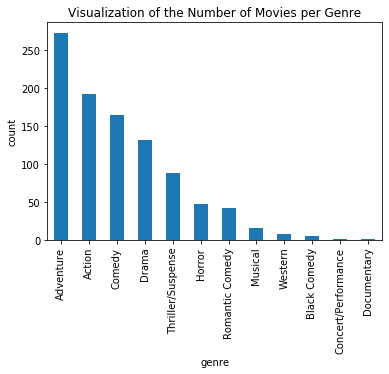

In [55]:
#Using our bar_graph_count function to visualize the movies_genre group 
#It takes the following inputs: df, x_column, y_column, title
movies_dom_genre.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_dom_genre, "genre", "count", "Visualization of the Number of Movies per Genre")

In [56]:
#Creating a data frame of the movies creative_type count 
movies_ct = groupby_count(movies_dom, "creative_type", "creative_type") 
movies_ct["creative_type"]

0    Contemporary Fiction
1           Dramatization
2                 Factual
3                 Fantasy
4      Historical Fiction
5            Kids Fiction
6         Science Fiction
7              Super Hero
Name: creative_type, dtype: category
Categories (8, object): [Contemporary Fiction, Dramatization, Factual, Fantasy, Historical Fiction, Kids Fiction, Science Fiction, Super Hero]

Text(0.5, 0, 'creative_type')

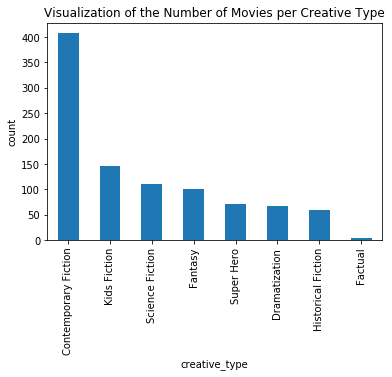

In [57]:
#Sorting the df, so the bar graph will be in descending order
movies_ct.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_ct, "creative_type", "count", "Visualization of the Number of Movies per Creative Type")


In [58]:
movies_year = groupby_count(movies_dom, "year", "genre")
movies_year

,count,year
0,17,2000
1,45,2001
2,47,2002
3,52,2003
4,53,2004
5,42,2005
6,55,2006
7,44,2007
8,53,2008
9,49,2009


Text(0.5, 0, 'year')

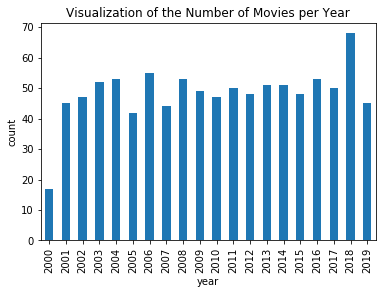

In [59]:
bar_graph_count(movies_year, "year", "count", "Visualization of the Number of Movies per Year")


In [60]:
movies_month = groupby_count(movies_dom, "month", "genre")
movies_month

,count,month
0,38,1
1,64,2
2,82,3
3,50,4
4,101,5
5,116,6
6,108,7
7,71,8
8,47,9
9,55,10


Text(0.5, 0, 'month')

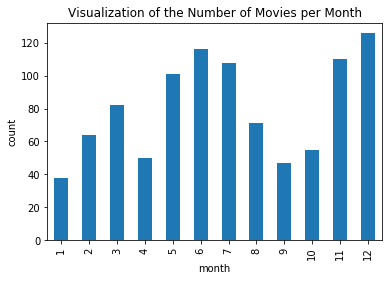

In [61]:
bar_graph_count(movies_month, "month", "count", "Visualization of the Number of Movies per Month")

In [62]:
movies_source = groupby_count(movies_dom, "source", "genre")
movies_source

,count,source
0,88,Based on Comic/Graphic Novel
1,39,Based on Factual Book/Article
2,201,Based on Fiction Book/Short Story
3,12,Based on Folk Tale/Legend/Fairytale
4,8,Based on Game
5,2,Based on Movie
6,2,Based on Musical or Opera
7,5,Based on Play
8,39,Based on Real Life Events
9,2,Based on Religious Text


Text(0.5, 0, 'source')

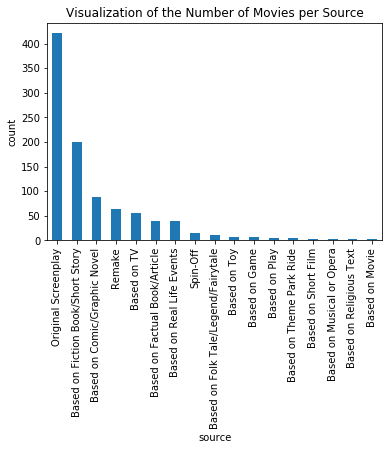

In [63]:
movies_source.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_source, "source", "count", "Visualization of the Number of Movies per Source")

In [64]:
movies_distributor = groupby_count(movies_dom, "distributor", "genre")
movies_distributor

,count,distributor
0,131,20th Century Fox
1,19,Dreamworks SKG
2,1,FilmDistrict
3,7,Focus Features
4,6,Fox Searchlight
5,40,Lionsgate
6,9,MGM
7,11,Miramax
8,7,Miramax/Dimension
9,21,New Line


In [65]:
movies_distributor = movies_distributor[movies_distributor["count"] > 0]
movies_distributor

,count,distributor
0,131,20th Century Fox
1,19,Dreamworks SKG
2,1,FilmDistrict
3,7,Focus Features
4,6,Fox Searchlight
5,40,Lionsgate
6,9,MGM
7,11,Miramax
8,7,Miramax/Dimension
9,21,New Line


Text(0.5, 0, 'distributor')

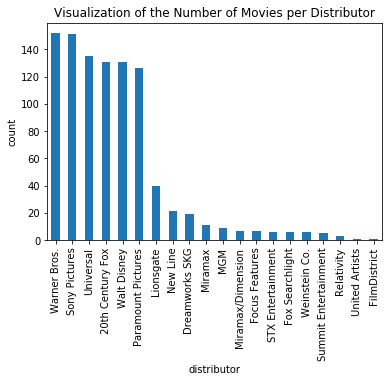

In [66]:
movies_distributor.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_distributor, "distributor", "count", "Visualization of the Number of Movies per Distributor")

In [67]:
movies_production_method = groupby_count(movies_dom, "production_method", "genre")
movies_production_method

,count,production_method
0,87,Animation/Live Action
1,110,Digital Animation
2,8,Hand Animation
3,762,Live Action
4,1,Stop-Motion Animation


Text(0.5, 0, 'production_method')

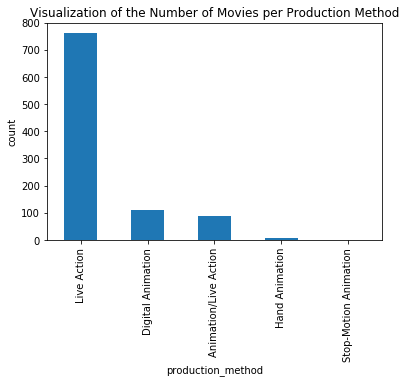

In [68]:
movies_production_method.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_production_method, "production_method", "count", "Visualization of the Number of Movies per Production Method")

In [69]:
######################################################################################################################
#
# We are ready to create our testing and training dfs, we are going to see if we can predict percent_profit 
# For the domestic movies we have a company called "Flops are Us" and we want to see if we can predict if a 
# movie will be a flop or not after the first weekend. 
#
# We will also try to predict percent profit without the open_wkend_rev and open_wken_rev/open_wkend_theaters
#
######################################################################################################################

In [71]:
#################################################################
#Naive Bayes 
#**All Numerica Data *** 
#################################################################

In [206]:
#Creating a test_train df for each of our 3 dfs 
test_train_movies_dom = movies_dom.copy() 
test_train_movies_int = movies_int.copy() 
test_train_movies_ww  = movies_ww.copy() 

In [207]:
test_train_movies_dom.columns
#Need to remove "creative_type", "genre", "production_method", "released", "source", "distributor", "title"
columns_to_remove = ["creative_type", "genre", "production_method", "released", "source", "distributor", "title", "open_wkend_rev/open_wkend_theaters", "open_wkend_rev", "budget", "year", "month", "day", "open_wkend_theaters"]
columns_to_remove_ex = ["dom_cumulative_mean_creative_type", "dom_cumulative_mean_genre", "dom_cumulative_mean_production_method", 
                       "dom_cumulative_mean_source", "dom_cumulative_mean_distributor", "dom_cumulative_mean_month"]
columns_to_remove_cumulative = ["dom_exp_mean_creative_type", "dom_exp_mean_genre", "dom_exp_mean_production_method", 
                       "dom_exp_mean_source", "dom_exp_mean_distributor", "dom_exp_mean_month"]
test_train_movies_dom.drop(columns_to_remove, axis = 1, inplace = True)
test_train_movies_dom_ex = test_train_movies_dom.copy() 
test_train_movies_dom_cumulative = test_train_movies_dom.copy() 
test_train_movies_dom_ex.drop(columns_to_remove_ex, axis = 1, inplace = True)
test_train_movies_dom_cumulative.drop(columns_to_remove_cumulative, axis = 1, inplace = True)

In [208]:
test_train_movies_dom.columns

Index(['dom_percent_profit', 'dom_cumulative_mean_creative_type',
       'dom_exp_mean_creative_type', 'dom_cumulative_mean_genre',
       'dom_exp_mean_genre', 'dom_cumulative_mean_production_method',
       'dom_exp_mean_production_method', 'dom_cumulative_mean_source',
       'dom_exp_mean_source', 'dom_cumulative_mean_distributor',
       'dom_exp_mean_distributor', 'dom_cumulative_mean_month',
       'dom_exp_mean_month'],
      dtype='object')

In [209]:
test_train_movies_int.columns
#Need to remove "creative_type", "genre", "production_method", "released_ww", "source", "distributor", "title"
columns_to_remove = ["creative_type", "genre", "production_method", "released_ww", "source", "distributor", "title"]
test_train_movies_int.drop(columns_to_remove, axis = 1, inplace = True)

In [210]:
test_train_movies_ww.columns 
#Need to remove "creative_type", "genre", "production_method", "released_ww", "released", "source", "distributor", "title"
columns_to_remove = ["creative_type", "genre", "production_method", "released_ww", "released", "source", "distributor", "title"]
test_train_movies_ww.drop(columns_to_remove, axis = 1, inplace = True)

In [211]:
#We have to descritze percent profit... We are interested if we will have a negative percent profit or a positive percent profit 
categories = ["negative", "positive"]
#Negative anything less than or equal to .0001 
#positive anything greater than .0001 
test_train_movies_dom["percent_profit"] = pd.cut(test_train_movies_dom["dom_percent_profit"], [-101, 0.0001, 999999], labels = categories)
test_train_movies_dom_ex["percent_profit"] = pd.cut(test_train_movies_dom["dom_percent_profit"], [-101, 0.0001, 999999], labels = categories)
test_train_movies_dom_cumulative["percent_profit"] = pd.cut(test_train_movies_dom["dom_percent_profit"], [-101, 0.0001, 999999], labels = categories)

# test_train_movies_int["percent_profit"] = pd.cut(test_train_movies_int["int_percent_profit"], [-101, 0.0001, 999999], labels = categories)
# test_train_movies_ww["percent_profit"] = pd.cut(test_train_movies_ww["ww_percent_profit"], [-101, 0.0001, 999999], labels = categories)

In [212]:
#Getting the count of each category in our test_train_movies_dom df 
test_train_movies_dom_count = test_train_movies_dom.groupby("percent_profit")["percent_profit"].count()
test_train_movies_dom_count

percent_profit
negative    204
positive    764
Name: percent_profit, dtype: int64

In [213]:
# We are going to create a testing and training df that contains 386 negative, 386 positive percent_profits  
#First we are going to subset the positive percent profits and the negative per+cent_profits 
positive = test_train_movies_dom[test_train_movies_dom["percent_profit"] == "positive"]
test_train_movies_dom = test_train_movies_dom[test_train_movies_dom["percent_profit"] == "negative"]

positive_ex = test_train_movies_dom_ex[test_train_movies_dom_ex["percent_profit"] == "positive"]
test_train_movies_dom_ex = test_train_movies_dom_ex[test_train_movies_dom_ex["percent_profit"] == "negative"]

positive_cumulative = test_train_movies_dom_cumulative[test_train_movies_dom_cumulative["percent_profit"] == "positive"]
test_train_movies_dom_cumulative = test_train_movies_dom_cumulative[test_train_movies_dom_cumulative["percent_profit"] == "negative"]
#Getting the length to make sure that we have 204 negative, 771 postive in our df 
print(len(positive))
print(len(test_train_movies_dom))

764
204


In [214]:
#Now getting a random sample of 198 entries in the positive df and setting the seed to 123
#to reproduce the results 
positive = positive.sample(n = 204, random_state = 1201)
positive_ex = positive_ex.sample(n = 204, random_state = 1201)
positive_cumulative = positive_cumulative.sample(n = 204, random_state = 1201)
#Getting the length to make sure that it worked 
print(len(positive))

204


In [215]:
#Adding the positive movies back to the test_train_movies_pp df 
test_train_movies_dom = pd.concat([test_train_movies_dom, positive])
test_train_movies_dom_ex = pd.concat([test_train_movies_dom_ex, positive_ex])
test_train_movies_dom_cumulative = pd.concat([test_train_movies_dom_cumulative, positive_cumulative])
#Getting the length to make sure that the 2 df were combined correctly and if it did we would have 408 movies in our df
len(test_train_movies_dom)

408

In [216]:
# #Repeating the process for test_train_movies_int
# #Getting the count of each category in our test_train_movies_int df 
# test_train_movies_int_count = test_train_movies_int.groupby("percent_profit")["percent_profit"].count()
# test_train_movies_int_count

In [217]:
# # We are going to create a testing and training df that contains 420 negative, 420 positive percent_profits  
# #First we are going to subset the positive percent profits and the negative per+cent_profits 
# positive = test_train_movies_int[test_train_movies_int["percent_profit"] == "positive"]
# test_train_movies_int = test_train_movies_int[test_train_movies_int["percent_profit"] == "negative"]
# #Getting the length to make sure that we have 229 negative, 739 postive in our df 
# print(len(positive))
# print(len(test_train_movies_int))

In [218]:
# #Now getting a random sample of 420 entries in the positive df and setting the seed to 123
# #to reproduce the results 
# positive = positive.sample(n = 229, random_state = 1201)
# #Getting the length to make sure that it worked 
# print(len(positive))

In [219]:
# #Adding the positive movies back to the test_train_movies_pp df 
# test_train_movies_int = pd.concat([test_train_movies_int, positive])
# #Getting the length to make sure that the 2 df were combined correctly and if it did we would have 458 movies in our df
# len(test_train_movies_int)

In [220]:
# #Repeating the process for test_train_movies_ww 
# #Getting the count of each category in our test_train_movies_ww df 
# test_train_movies_ww_count = test_train_movies_ww.groupby("percent_profit")["percent_profit"].count()
# test_train_movies_ww_count

In [221]:
#We do not have sufficient information to predict a negative or positive percent profit for world wide movies 
# We need more movies with a negative world wide percent profit... Although this is extremely interesting and 
# suggests that movies that have a negative domestic profit should release the movie internationally to recover 

In [222]:
# #Changing the data type of month day and year to numeric
# columns = ["month", "day"]
# columns_ww = ["month_ww", "day_ww"]
# test_train_movies_dom[columns] = test_train_movies_dom[columns].apply(pd.to_numeric)
# test_train_movies_dom_ex[columns] = test_train_movies_dom_ex[columns].apply(pd.to_numeric)
# test_train_movies_dom_cumulative[columns] = test_train_movies_dom_cumulative[columns].apply(pd.to_numeric)

# # test_train_movies_ww[columns_ww] = test_train_movies_ww[columns_ww].apply(pd.to_numeric)

In [223]:
# test_train_movies_dom.reset_index(inplace = True)
# test_train_movies_int.reset_index(inplace = True)

# test_train_movies_dom.drop("level_0", axis = 1, inplace = True)
# test_train_movies_int.drop("level_0", axis = 1, inplace = True)

In [224]:
# #removing the label from the test_train_movies_dom and int df and saving it in a label df
test_train_movies_dom_label = test_train_movies_dom["percent_profit"]
test_train_movies_dom.drop("percent_profit", axis = 1, inplace = True)
test_train_movies_dom_ex_label = test_train_movies_dom_ex["percent_profit"]
test_train_movies_dom_ex.drop("percent_profit", axis = 1, inplace = True)
test_train_movies_dom_cumulative_label = test_train_movies_dom_cumulative["percent_profit"]
test_train_movies_dom_cumulative.drop("percent_profit", axis = 1, inplace = True)
#repeating the process for int
# test_train_movies_int_label = test_train_movies_int["percent_profit"]
# test_train_movies_int.drop("percent_profit", axis = 1, inplace = True)


In [225]:
#Creating 4 df: 1: the training df with label removed, 2: the testing df with label removed, 3: the training label, 4: testing label
from sklearn.model_selection import train_test_split 
dom_train, dom_test, dom_train_label, dom_test_label = train_test_split(test_train_movies_dom, test_train_movies_dom_label, test_size = .3, random_state = 116)
dom_ex_train, dom_ex_test, dom_ex_train_label, dom_ex_test_label = train_test_split(test_train_movies_dom_ex, test_train_movies_dom_ex_label, test_size = .3, random_state = 116)
dom_cum_train, dom_cum_test, dom_cum_train_label, dom_cum_test_label = train_test_split(test_train_movies_dom_cumulative, test_train_movies_dom_cumulative_label, test_size = .3, random_state = 116)
# int_train, int_test, int_train_label, int_test_label = train_test_split(test_train_movies_int, test_train_movies_int_label, test_size = .3, random_state = 123)

In [226]:
#Getting a count of percent_profit in our test label  scores in out test label
#We want to have roughly the same number of positive and negative movies in our test df
print(Counter(dom_test_label)) 
# print(Counter(int_test_label))

Counter({'negative': 62, 'positive': 61})


In [227]:
#Using the standard scale to help preprocess and normalize the data 
# performing preprocessing part 
sc = StandardScaler()
dom_train = sc.fit_transform(dom_train)
dom_test = sc.transform(dom_test)

dom_ex_train = sc.fit_transform(dom_ex_train)
dom_ex_test = sc.transform(dom_ex_test)

dom_cum_train = sc.fit_transform(dom_cum_train)
dom_cum_test = sc.transform(dom_cum_test)
# int_train = sc.fit_transform(int_train)
# int_test = sc.transform(int_test)

In [228]:
#Attempt 1: all variables
clf = GaussianNB()
clf.fit(dom_train, dom_train_label)
test_predicted_dom_nb = clf.predict(dom_test)

clf.fit(dom_ex_train, dom_ex_train_label)
test_predicted_dom_ex_nb = clf.predict(dom_ex_test)

clf.fit(dom_cum_train, dom_cum_train_label)
test_predicted_dom_cum_nb = clf.predict(dom_cum_test)

# clf.fit(int_train, int_train_label)
# test_predicted_int_nb = clf.predict(int_test)

Text(0.5, 1, 'Dom Accuracy Score: 0.9024')

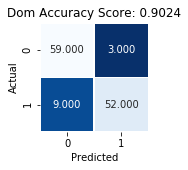

In [229]:
#Accuracy for dom 
dom_accuracy_nb = accuracy_score(dom_test_label, test_predicted_dom_nb, normalize = True)
cm = confusion_matrix(dom_test_label, test_predicted_dom_nb)
confusion_matrix_graph(cm, dom_accuracy_nb, "Dom")

Text(0.5, 1, 'Dom Accuracy Score: 0.935')

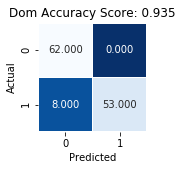

In [230]:
dom_ex_accuracy_nb = accuracy_score(dom_ex_test_label, test_predicted_dom_ex_nb, normalize = True)
cm = confusion_matrix(dom_ex_test_label, test_predicted_dom_ex_nb)
confusion_matrix_graph(cm, dom_ex_accuracy_nb, "Dom")

Text(0.5, 1, 'Dom Accuracy Score: 0.9024')

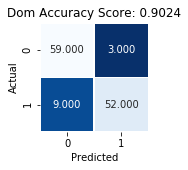

In [231]:
dom_cum_accuracy_nb = accuracy_score(dom_cum_test_label, test_predicted_dom_cum_nb, normalize = True)
cm = confusion_matrix(dom_cum_test_label, test_predicted_dom_cum_nb)
confusion_matrix_graph(cm, dom_cum_accuracy_nb, "Dom")